## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 2

- **100 points [7% of your final grade]**
- **Due Sunday, March 6 by 11:59pm** 
- (*no submissions accepted after March 9 by 11:59pm*)

**Goals of this homework:** There are four objectives of this homework: 

* Become familiar with Apache Spark;
* Get hands-on experience using Spark built-in functions like PageRank;
* Work out Hubs and Authorities by hand;
* Try some LSH problems.

*Submission instructions:* You should post your notebook to canvas (look for the homework 2 assignment there). Name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. When you are done, download your notebook from colab and submit it to canvas.

*Collaboration declaration:* If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

*Write your collaboration/references here*

## Preliminaries: Introduction to the Dataset
We will use a dataset of tweets concerning members of the US congress. The data spans almost a year (from October 3rd, 2018 to September 25th, 2019) covering 576 of the members. Any tweet or retweet posted by the 576 members or directed to them by other Twitter users were collected.

Originally there were more than 200 million tweets collected but we have sampled 400,000 tweets for this homework.

Below is a summary of all datasets used for this homework:

| Dataset                        | Description |
| :---                                                       | :---
| Congress members               | 576 twitter ids and screen names |
| Sample tweets                  |400k sample tweets|
| ~~User hashtags~~                  | ~~all pairs of <user, hashtag>~~|
| User mentions                  | all pairs of <src_user_id, src_dest_id, frequency> |



Following are the steps that you need to execute to install spark. Remember you need to execute them everytime after your runtime is disconnected

In [1]:
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  242k  100  242k    0     0   887k      0 --:--:-- --:--:-- --:--:--  887k


The cell below will download the dataset from S3 to us-congress-tweets directory

In [2]:
!mkdir us-congress-tweets
!wget https://us-congress.s3.amazonaws.com/congress_members.csv -O us-congress-tweets/congress_members.csv
!wget https://us-congress.s3.amazonaws.com/tweets-sample-400k.json -O us-congress-tweets/tweets-sample-400k.json
!wget https://us-congress.s3.amazonaws.com/user_hashtags-1m.csv -O us-congress-tweets/user_hashtags-1m.csv
!wget https://us-congress.s3.amazonaws.com/user_mentions.csv -O us-congress-tweets/user_mentions.csv

mkdir: cannot create directory ‘us-congress-tweets’: File exists
--2022-03-07 05:20:41--  https://us-congress.s3.amazonaws.com/congress_members.csv
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.166.121
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.166.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13835 (14K) [text/csv]
Saving to: ‘us-congress-tweets/congress_members.csv’

us-congress-tweets/ 100%[===================>]  13.51K  --.-KB/s    in 0s      

2022-03-07 05:20:41 (97.1 MB/s) - ‘us-congress-tweets/congress_members.csv’ saved [13835/13835]

--2022-03-07 05:20:42--  https://us-congress.s3.amazonaws.com/tweets-sample-400k.json
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.166.121
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.166.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202495914

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [4]:
# create a Spark session
conf = SparkConf().set("spark.ui.port", "4050")

# create a Spark context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


In [5]:
# First let's read Twitter ids and screen names of the 576 US congress members

congress_members = spark.read.csv("us-congress-tweets/congress_members.csv", header=True)
congress_members.show()
print("Number of congress members tracked:", congress_members.count())

+------------------+---------------+
|            userid|    screen_name|
+------------------+---------------+
|         776664410|  RepCartwright|
|         240363117|   RepTomMarino|
|837722935095930883| RepScottTaylor|
|        1069124515|     RepLaMalfa|
|818460870573441028|  RepTomGarrett|
|         163570705|     repcleaver|
|          19739126|      GOPLeader|
|          33563161| RepJoseSerrano|
|        2861616083|USRepGaryPalmer|
|        1074518754| SenatorBaldwin|
|         305620929|  Call_Me_Dutch|
|         381152398| RepTerriSewell|
|         834069080| RepDavidRouzer|
|         249787913|  SenatorCarper|
|         188019606|        Clyburn|
|         217543151|SenatorTimScott|
|          39249305| USRepMikeDoyle|
|          33537967|   amyklobuchar|
|         249410485|  SanfordBishop|
|          23124635|    TomColeOK04|
+------------------+---------------+
only showing top 20 rows

Number of congress members tracked: 576


We can use `spark.read.json(...)` without schema to load the tweets into a dataframe but this will be slow for two reasons:
* First, it will make one pass over the data to build a schema of the content, then a second pass to read the content and parse it to the dataframe. 
* It will read all the content of the Tweet JSON objects but we only need few fields for a given task.

Thus we define our own schema something like the following:

In [6]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
twitter_date_format="EEE MMM dd HH:mm:ss ZZZZZ yyyy"

user_schema = StructType([
    StructField('created_at', TimestampType(), True),
    StructField('followers_count', LongType(), True),
    StructField('id', LongType(), True),
    StructField('name', StringType(), True),
    StructField('screen_name', StringType(), True)
])

hashtag_schema = ArrayType(StructType([StructField('text', StringType(), True)]))
user_mentions_schema = ArrayType(StructType([StructField('id', LongType(), True),
                                             StructField('screen_name', StringType(), True)]))
entities_schema = StructType([
    StructField('hashtags', hashtag_schema, True),
    StructField('user_mentions', user_mentions_schema, True)
    ])

retweeted_status_schema =StructType([        
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema)
    ])

tweet_schema =StructType([
        StructField("text", StringType(), True),
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema),
        StructField("entities", entities_schema),
        StructField("retweeted_status", retweeted_status_schema)
    ])

Now we are ready to read the tweets with `spark.read.json` passing our own schema as follows:

In [7]:
tweets = spark.read.option("timestampFormat", twitter_date_format)\
                   .json('us-congress-tweets/tweets-sample-400k.json', tweet_schema)\
                   .withColumn('user_id',F.col('user.id'))
tweets.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: timestamp (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- in_reply_to_user_id: long (nul

## (30 points) Part 1: Let's Fire up Spark for Real

Okay, now that we've finally got our data loaded, we are ready to get our hands dirty with Spark. As you know, Spark comes with lots of built-in functions and nice capabilities. Indeed, you will find that to answer the problems below, there are **many** possible approaches. Please refer to the Stanford Spark tutorial we posted alongside this homework. Also feel free to Google around for some Spark resources, but we list a few here to get you started:

* https://spark.apache.org/docs/latest/sql-ref-functions-builtin.html#aggregate-functions
* https://spark.apache.org/docs/latest/sql-getting-started.html#running-sql-queries-programmatically


### Exploratory Data Analysis

a) How many unique users are there? 

In [8]:
# your code here for unique users

tweets.createOrReplaceTempView("tweets")
#Creates or replaces a local temporary view 
unique_users = spark.sql("SELECT count(distinct user_id) as unique_user_count FROM tweets ")
print("Unique user count is ")
unique_users.show()

Unique user count is 
+-----------------+
|unique_user_count|
+-----------------+
|           198097|
+-----------------+



b) How many times is the user **GOPLeader** mentioned?


In [9]:
# code here
from pyspark.sql.functions import explode

GOPLeader_df=tweets.select(tweets.id.alias("id"), explode(tweets.entities.user_mentions.screen_name).alias("user_mentions_"))
GOPLeader_df.createOrReplaceTempView("mentionsfor_GOPLeader")
GOPLeader_count = spark.sql("SELECT count(distinct id) as GOPLeader_member_count FROM mentionsfor_GOPLeader GROUP BY user_mentions_ HAVING user_mentions_ = 'GOPLeader'").show()

+----------------------+
|GOPLeader_member_count|
+----------------------+
|                  4728|
+----------------------+



c) Now find the top-5 most mentioned members of Congress.

In [10]:
# code here
from pyspark.sql.functions import explode
from pyspark.sql import Row
import pandas as pd

tweets.createOrReplaceTempView("tweets")
congress_members.createOrReplaceTempView("congress_members")

df_tweets=tweets.select(tweets.id.alias("id"), explode(tweets.entities.user_mentions.screen_name).alias("screen_name")).groupBy("screen_name").count()

print("Top five Members of Congress in mentioned tweets are")
temp=[]
for i in range(5):
  temp.append((pd.Index(df_tweets.orderBy("count", ascending= False ).toPandas().drop('count', axis =1)['screen_name']).intersection(pd.Index(congress_members.toPandas().drop('userid', axis = 1)['screen_name']))[0:5])[i])
print(temp)
df_tweets[df_tweets.screen_name.isin(temp)].orderBy("count", ascending= False ).show()

Top five Members of Congress in mentioned tweets are
['senatemajldr', 'LindseyGrahamSC', 'SenSchumer', 'RepAdamSchiff', 'marcorubio']
+---------------+-----+
|    screen_name|count|
+---------------+-----+
|   senatemajldr|15021|
|LindseyGrahamSC|14412|
|     SenSchumer|13738|
|  RepAdamSchiff|13288|
|     marcorubio| 9957|
+---------------+-----+



d) For each month in the dataset, report the top-5 most mentioned users (across all users in the dataset, not just the members of Congress). 

In [11]:
# code here

from pyspark.sql.functions import explode,month

temp_df=tweets.select(tweets.id.alias("id"), tweets.created_at.alias("time"), explode(tweets.entities.user_mentions.screen_name).alias("user"))


for iter in range(12):
  (temp_df.withColumn('month',month(temp_df.time))).groupBy("user").pivot("month").count().select("user", str(iter+1)).sort(str(iter+1), ascending=False).show(5)

+---------------+----+
|           user|   1|
+---------------+----+
|realDonaldTrump|4154|
|  SpeakerPelosi|3318|
|     SenSchumer|2797|
|   senatemajldr|2577|
|LindseyGrahamSC|1818|
+---------------+----+
only showing top 5 rows

+---------------+----+
|           user|   2|
+---------------+----+
|     marcorubio|1883|
|realDonaldTrump|1807|
|  RepAdamSchiff|1172|
|  SpeakerPelosi|1141|
|     SenSanders|1083|
+---------------+----+
only showing top 5 rows

+---------------+----+
|           user|   3|
+---------------+----+
|  RepAdamSchiff|2301|
|realDonaldTrump|1906|
|LindseyGrahamSC|1570|
|     marcorubio|1494|
|  SpeakerPelosi|1120|
+---------------+----+
only showing top 5 rows

+---------------+----+
|           user|   4|
+---------------+----+
|  RepAdamSchiff|1843|
|realDonaldTrump|1410|
|  SpeakerPelosi|1206|
|     SenSchumer| 967|
| RepJerryNadler| 924|
+---------------+----+
only showing top 5 rows

+---------------+----+
|           user|   5|
+---------------+----+
|Li

e) Do you notice anything interesting in your monthly analysis?

*your answer here*

One thing, former President Mr. Donald Trump aka realDonaldTrump was mentioned every month Jan -Dec and has consistently been in top five mentions.



## (25 points) Part 2: PageRank
Now let's find out who are the most important users in the dataset by running PageRank over the mentions network. For this problem, we'll define a user-mentions network using relations in `us-congress-tweets/user_mentions.csv`. That is, each user is a node in the graph. If user A mentions user B, then there should be an edge from A to B.

Hint:
* Take a look at GraphFrames: https://graphframes.github.io/graphframes/docs/_site/user-guide.html


In [12]:
# your network construction code here
# !pip install graphframes
# from graphframes.examples import Graphs
from graphframes import *
#Edge Dataframe
Congress_user_mentions = spark.read.csv("us-congress-tweets/user_mentions.csv", header = True)
#Vertex Dataframe
vertex_v = (Congress_user_mentions.select("src").distinct()).union(Congress_user_mentions.select("dst").distinct()).distinct().withColumnRenamed("src", "id")
#creating graph g=(v,e) as per definition
graph_g = GraphFrame(vertex_v, Congress_user_mentions)

How many vertices are there in your network? And how many edges?

In [13]:
# your code
#Vertex Count
print("Vertices count in the User Mentions Network:",vertex_v.count())
#Edge Count
print("Edge count in the User Mentions Network:",Congress_user_mentions.count())

Vertices count in the User Mentions Network: 1133350
Edge count in the User Mentions Network: 2064872


Now you can run PageRank on the constructed network. Feel free to use the implementation provided as part of GraphFrames. Use a reset (or teleportation probability) of 0.15. 

In [14]:
# your PageRank code here (should be pretty short since you're just calling a function)
#
PageRank_network = graph_g.pageRank(resetProbability=0.15, maxIter=5)

OK, let's see what we found. List the top-10 users based on the PageRank values calculated above.

In [15]:
# Top 10 accounts 
# SparkConf.setExecutorEnv("memory","4g")
print("Top 10 users based on PageRank")
# PageRank_network.vertex_v.orderBy(PageRank_network.vertex_v.pagerank, ascending = False).show(10)
PageRank_network.vertices.orderBy("pagerank", ascending = False).show(10)


Top 10 users based on PageRank
+------------------+-----------------+
|                id|         pagerank|
+------------------+-----------------+
|         240393970|7036.967000240482|
|          25073877|6701.685539517161|
|822215679726100480|6284.148813341785|
|        4924463189|5981.435708340409|
|        1249982359|5587.588320042423|
|          15764644|5061.313584770873|
|         242555999|4998.188411171005|
|          15808765|4698.204423833516|
|          29442313|4406.403704515815|
|          17494010|4387.808250973902|
+------------------+-----------------+
only showing top 10 rows



What do you observe? are the top 10 users congress members? are there outsiders?

Hint: You can use https://twitter.com/intent/user?user_id=? to find out more info about the users

*your analysis here*
Of the ten users listed above, there are three non-congress members

---


id-25073877---> screen_name-realDonaldTrump

---
id-822215679726100480---> screen_name-POTUS


---
id-4924463189---> screen_name-null



## (5 points) Bonus Question (Optional)
Until now you have explored different aspects of Spark to investigate tweets by the US Congress. For this (optional) bonus problem, please conduct your own investigation of the data. You can use any combinations of the data files to carry out your investigation. You may use any libraries in Spark that you like, but you must use Spark. Tell us what question motivates you, what you did, what you discovered, and why it is interesting. This is completely open-ended, but we are looking for compelling questions and insights. Good luck!



Feel free to add any number of code/text cells here for your answer!


So far, we have explored tweets data, congress members data. For this bonus question, I want to explore the trending Hashtags in tweets. 

In [16]:
print("Trending Hashtags:")
tweets.select(tweets.id,explode(tweets.entities.hashtags)).groupBy("col").count().orderBy("count", ascending = False).show(5)

Trending Hashtags:
+---------------+-----+
|            col|count|
+---------------+-----+
|    {Venezuela}| 1224|
|  {MoscowMitch}| 1123|
|{TrumpShutdown}|  705|
|         {MAGA}|  535|
|{MuellerReport}|  396|
+---------------+-----+
only showing top 5 rows



## (20 points) Hubs and Authorities by Hand

Consider the following graph (in adjacency list format):

* A: B, D (that is, A links to B and to D)
* B: D, E
* C: D, E
* D: F, G
* E: C, D, G, H
* F: 
* G: 
* H: C, G

Find the hub and authority score for each node. Please normalize your final scores so they sum to 1.

*show your steps here*

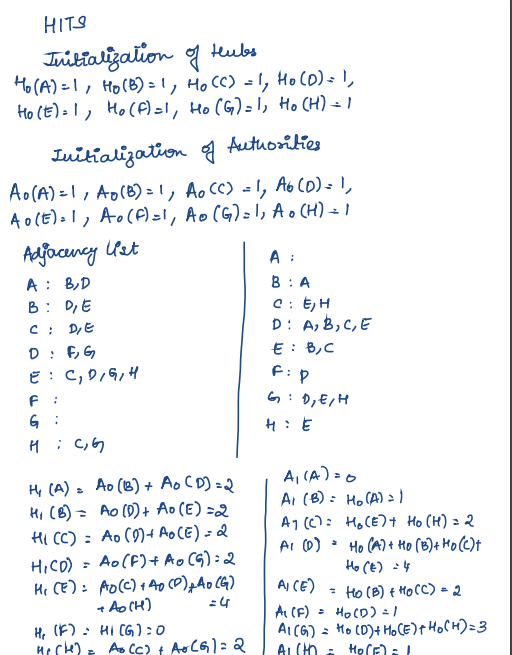

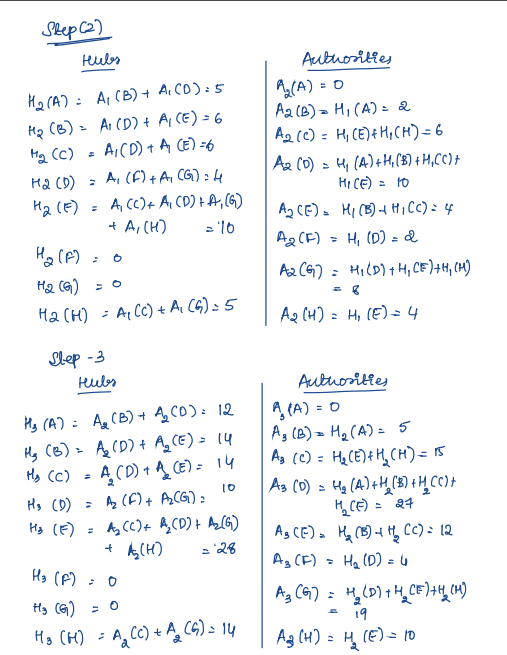

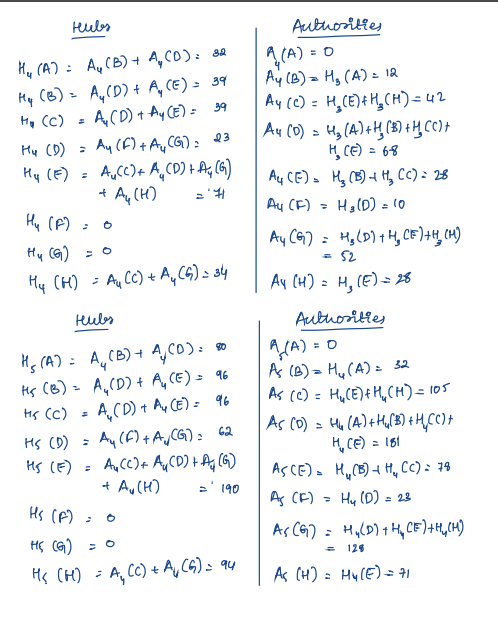

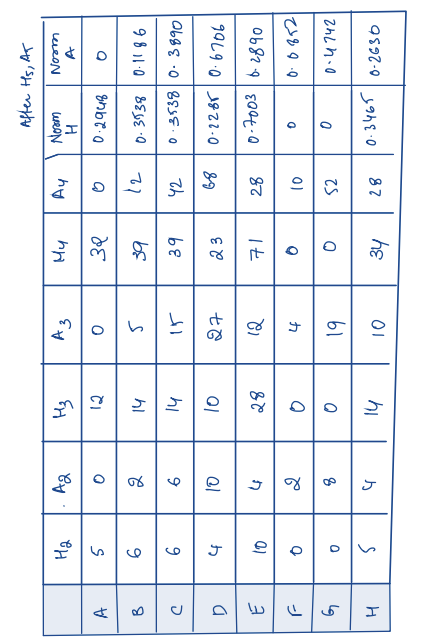

for clarification 

h5(A)=80, h5(B)=96, h5(C)=96, h5(D)=62, h5(E)=190, h5(F)=0, h5(G)=0, h5(H)=94

a5(A)=0, a5(B)=32, a5(C)=105, a5(D)=181, a5(E)=78, a5(F)=23, a5(G)=128, a5(H)=71


## (25 points) LSH Problems from the Book

From MMDS [Chapter 3](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf), do the following problems:

* Exercise 3.1.2 (Page 78)
* Exercise 3.2.2 (Page 81)
* Exercise 3.3.3 (Page 90)
* Exercise 3.4.1 (Page 96)
* Exercise 3.4.2 (Page 96)

Please add cells below with your answers (explanation and detail of calculation are required). 


**Exercise 3.1.2**

Let's assume
a={1,1,1,2}
b={1,1,2,2,3}
c={1,2,3,4}

Jaccard Bag Similarity of A & B

a={1,1,1,2}

b={1,1,2,2,3}

size(a ∩ b) =2+1=3

size(a ∪ b) = 5+3+1=9

Jaccard similarity = len(a ∩ b)/len(a ∪ b)=3/9 =1/3


---


Jaccard Bag Similarity of B & C

b={1,1,2,2,3}

c={1,2,3,4}

size(b ∩ c) =1+1+1=3

size(b ∪ c) =3+3+2+1=9

Jaccard Similarity =len(b ∩ c)/len(b ∪ c)=3/9 =1/3


---

Jaccard Bag Similarity of A & C

a={1,1,1,2}

c={1,2,3,4}

size(a ∩ c) =1+1=2

size(a ∪ c) =4+2+1+1=8

Jaccard Similarity =len(a ∩ c)/len(a ∪ c)=2/8 =1/4







**Exercise 3.2.2**

Stop words are common words with three or fewer letters such as of, is, are, etc.

Stop-word-based singles one of the useful set of shingles that are a combination of stop word followed by the next two words, regardless of whether or not they were stop words.

Sentence: ***The*** most effective ***way*** ***to*** represent documents ***as*** sets, ***for*** ***the*** purpose ***of*** identifying lexically similar documents ***is*** ***to*** construct from ***the*** document ***the*** ***set*** ***of*** short strings that appear within ***it***.

Shingles are:

1. ***The*** most effective

2. ***way*** ***to*** represent

3. ***to*** represent documents

4. ***as*** sets, ***for**

5. ***for*** ***the*** purpose

6. ***the*** purpose ***of**

7. ***of*** identifying lexically

8. ***is*** ***to*** construct

9. ***to*** construct from

10. ***the*** document ***the***

11. ***the*** ***set*** ***of***

12. ***set*** ***of*** short

13. ***of*** short strings


**Exercise 3.3.3**
Part-A

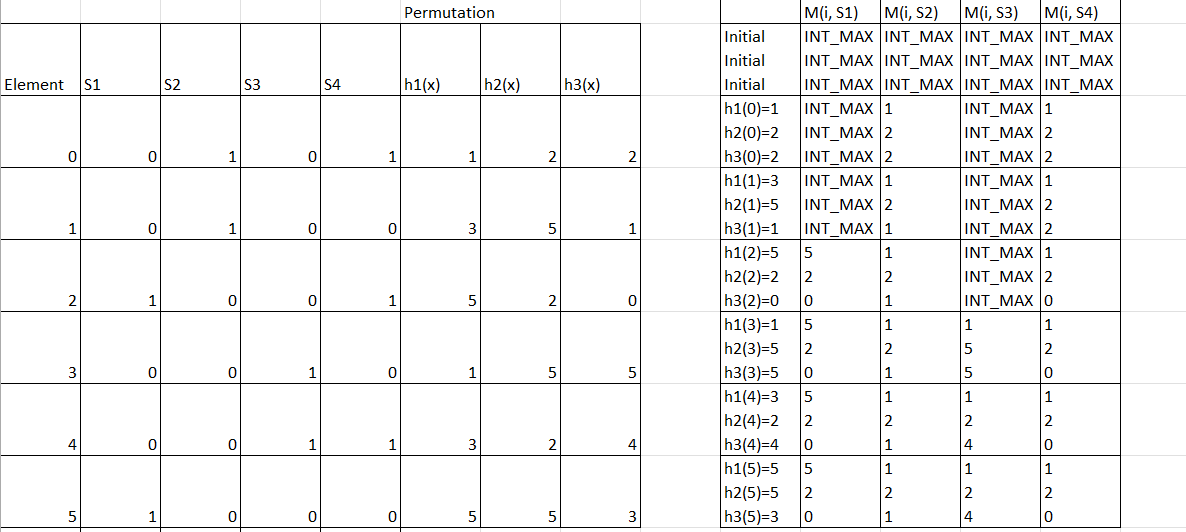

**PART-B**

If we observe the values generated by Hash functions h1, h2 and h3- in h1 and h2 we can see that hash values are repeating
h3 produces all distinct hash values hence h3 is a true permutation.

**PART-C**


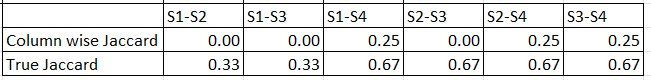

**Exercise 3.4.1**




s  S-Curve value
0 0.0
1 0.009955119790251765
2 0.07718058804273675
3 0.23944889319887064
4 0.4838707317677322
5 0.7369244238361716
6 0.9122674753991766
7 0.985015105295655
8 0.9992340538808936
9 0.9999978635491371


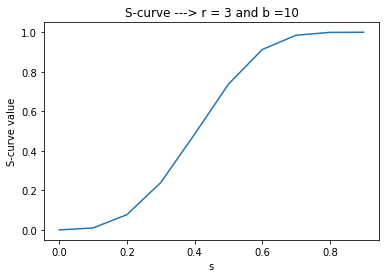

s  S-Curve value
0 0.0
1 1.9999810001669616e-05
2 0.001279222058761964
3 0.014479466504172311
4 0.07880932311056232
5 0.27018714400947597
6 0.6154146360312677
7 0.9181859965846744
8 0.9977121251546806
9 0.9999997398129465


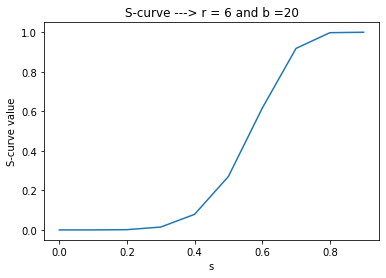

s  S-Curve value
0 0.0
1 0.0004998775195954597
2 0.01587519984502117
3 0.11453988231042189
4 0.4022839522088044
5 0.7955506304323648
6 0.9825338277068609
7 0.9998989958361557
8 0.9999999976077777
9 1.0


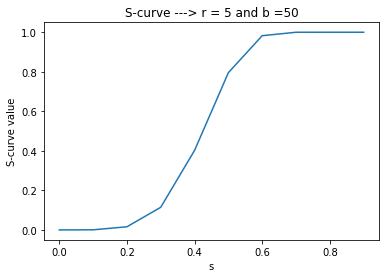

In [17]:
from math import pow as p
import matplotlib.pyplot as plt


s = [0.1*iter for iter in range(10)]
r = [3, 6, 5]
b = [10, 20, 50]

s_curve = np.zeros((3,10))

for i in range(3):
  print("s  S-Curve value")
  for j in range(10):
    s_curve[i][j] = 1 - p(1-p(s[j],r[i]),b[i])
    print(str(j),s_curve[i][j])
    
  s_temp = "S-curve ---> r = "+ str(r[i]) + " and b =" + str(b[i])
  plt.plot(s, s_curve[i])
  plt.title(s_temp)
  plt.xlabel("s")
  plt.ylabel("S-curve value")
  plt.show()

Let us consider s=0.8 and r=3, b=10

1-(0.8)**3 =1-0.512= 0.488

0.488**10= 0.000766

1-0.000766= 0.999234

This implies if we consider two documents with similarity of 80%, then roughly one in 1305 that are as similar as 80% will fail to become a candidate pair and thus a false negative.

---



Similarly we can calculate for parameters (r=6,b=20), (r=5,b=50)

Let us consider s=0.8 and r=6, b=20

1-(0.8)**6 =1-0.262144= 0.737856

0.737856^20= 0.002288

1-0.002288 = 0.997712

This implies if we consider two documents with similarity of 80%, then roughly one in 437 that are as similar as 80% will fail to become a candidate pair and thus a false negative.

As we see probability increased from previous case.







# **Exercise 3.4.2**

In [18]:
temp1=[]
for i in range(3):
  temp1.append( pow(1/b[i],1/r[i]))
  print("The calculated Estimated Threshold is as follows b ={}, c={}:{} ".format(b[i],r[i],temp1[i]))
  print("The estimated threshold value is ", 1 - p(1-p(temp1[i],r[i]),b[i]))
  

The calculated Estimated Threshold is as follows b =10, c=3:0.4641588833612779 
The estimated threshold value is  0.6513215599
The calculated Estimated Threshold is as follows b =20, c=6:0.6069622310029172 
The estimated threshold value is  0.6415140775914581
The calculated Estimated Threshold is as follows b =50, c=5:0.45730505192732634 
The estimated threshold value is  0.6358303199128832


In [22]:
temp2=[]
for i in range(3):
  temp2.append((1- (0.5 ** (1/b[i])))**(1/r[i]))
  print("Actual value is ",temp2[i] )

Actual value is  0.4060881340677083
Actual value is  0.5693533868256982
Actual value is  0.4243944803687326


In [21]:
#Finding the error in threshold value
for i in range(3):
  print("Percentage error for b ={}, c={} => {}".format(b[i],r[i], ((temp1[i]-temp2[i])/temp2[i])*100))


Percentage error for b =10, c=3 => 14.300035982801539
Percentage error for b =20, c=6 => 6.6055362183579245
Percentage error for b =50, c=5 => 7.754712438766775
